In [1]:
import numpy as np
import pickle
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
from sklearn.linear_model import Lasso
from scipy.stats import bernoulli
#import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from F import GL, Graph_Lasso, metric, X_gen, curve_auc, BIC #import classes/functions customized python script.
import warnings
warnings.filterwarnings("ignore")

# Edge set and data generation

In [2]:
P = 100 # dimension of features
N = 500 # number of random samples
delta = 0.5 # to generate the source matrix

In [6]:
obj = GL(P, delta, 0.1) 
source_matrix = obj.Matrix_generation() # generate the true edge set.
(source_matrix==0).sum()

8136

In [7]:
X = X_gen(source_matrix,N, random_state=0)

## Implementation of two methods

### Node-wise Lasso

In [31]:
gl = Graph_Lasso(X, 0.)
NWL = gl.NWL()
#NWL

### Graphical Lasso

In [43]:
GRL = gl.GRL(500)
#GRL

# ROC and Precision-Recall  curve for various values of $\lambda$ 

In [131]:
lambds = np.linspace(0,1,101)
FPR_g = []
TPR_g = []
F1_g = []
precision_g = []

FPR_n1 = []
TPR_n1 = []
F1_n1 = []
precision_n1 = []

FPR_n2 = []
TPR_n2 = []
F1_n2 = []
precision_n2 = []

for i in lambds:
    gl = Graph_Lasso(X, i)
    a = gl.GRL()
    b = gl.NWL()
    hashm_g = metric(source_matrix, a)
    hashm_n1 = metric(source_matrix, b, "joint")
    hashm_n2 = metric(source_matrix, b, "or")
    
    FPR_g.append(hashm_g.get("FPR", 0))
    TPR_g.append(hashm_g.get("TPR", 0))
    precision_g.append(hashm_g.get("precision", 0))
    F1_g.append(hashm_g.get("F1", 0))
    
    FPR_n1.append(hashm_n1.get("FPR", 0))
    TPR_n1.append(hashm_n1.get("TPR", 0))
    precision_n1.append(hashm_n1.get("precision", 0))
    F1_n1.append(hashm_n1.get("F1", 0))
    
    FPR_n2.append(hashm_n2.get("FPR", 0))
    TPR_n2.append(hashm_n2.get("TPR", 0))
    precision_n2.append(hashm_n2.get("precision", 0))
    F1_n2.append(hashm_n2.get("F1", 0))


Transfer original data to plot-friendly data and calculate the AUC of ROC curve.

In [132]:
tpr_g, fpr_g, auc_g = curve_auc(TPR_g, FPR_g)
tpr_n1, fpr_n1, auc_n1 = curve_auc(TPR_n1, FPR_n1)
tpr_n2, fpr_n2, auc_n2 = curve_auc(TPR_n2, FPR_n2)

precision_g, recall_g, area_g = curve_auc(precision_g, TPR_g, "PR")
precision_n1, recall_n1, area_n1  = curve_auc(precision_n1, TPR_n1, "PR")
precision_n2, recall_n2, area_n2  = curve_auc(precision_n2, TPR_n2, "PR")

I include all curves in one single plot for a more intuitive view(PR is the Precision-Recall curve):

The following gives the ROC curve and Precision-Recall curve with corresponding parameter values:

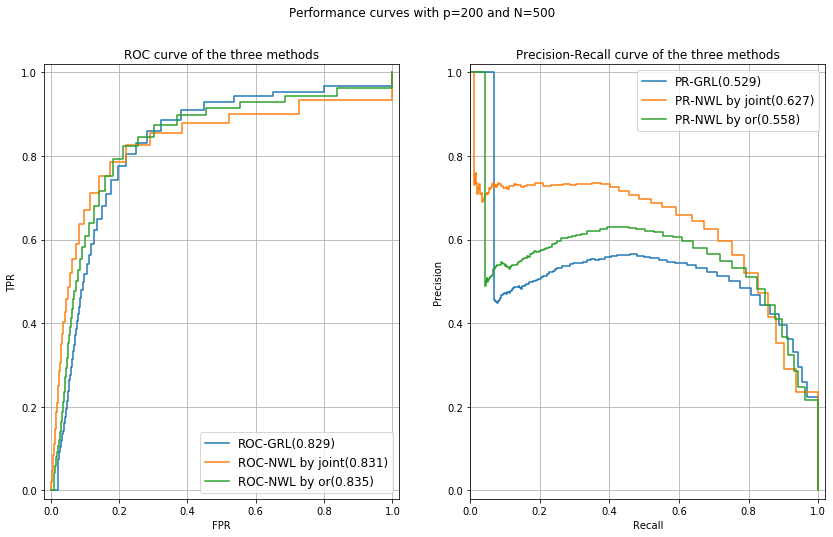

In [133]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(fpr_g, tpr_g, label=f"ROC-GRL({np.around(auc_g, decimals=3)})")
ax[0].plot(fpr_n1, tpr_n1, label=f"ROC-NWL by joint({np.around(auc_n1, decimals=3)})")
ax[0].plot(fpr_n2, tpr_n2, label=f"ROC-NWL by or({np.around(auc_n2, decimals=3)})")
ax[0].set_title("ROC curve of the three methods", fontsize=(12))
ax[0].set_xlabel("FPR", fontsize=(10))
ax[0].set_ylabel("TPR", fontsize=(10))

ax[1].plot(recall_g, precision_g, label=f"PR-GRL({np.around(area_g, decimals=3)})")
ax[1].plot(recall_n1, precision_n1, label=f"PR-NWL by joint({np.around(area_n1, decimals=3)})")
ax[1].plot(recall_n2, precision_n2, label=f"PR-NWL by or({np.around(area_n2, decimals=3)})")
ax[1].set_title("Precision-Recall curve of the three methods", fontsize=(12))
ax[1].set_xlabel("Recall", fontsize=(10))
ax[1].set_ylabel("Precision", fontsize=(10))

ax[0].legend(fontsize=(12))
ax[0].set_ylim(-0.02,1.02)
ax[0].set_xlim(-0.02,1.02)
ax[0].grid()
ax[1].legend(fontsize=(12))
ax[1].set_ylim(-0.02,1.02)
ax[1].set_xlim(0.,1.02)
ax[1].grid()
fig.suptitle("Performance curves with p=200 and N=500")
plt.savefig("Curve_P200.pdf")
plt.show()

# Parameter selection
In this part I use a function GraphicalLassoCV imported from sklearn package, and develop a CV method for Node-wise Lasso and BIC method for all threeto select the optimal tuning parameter $\lambda$. The results are compared to the true edge set.

In [30]:
gl = Graph_Lasso(X)

In [ ]:
gl.NWLCV() # estimation of inverse by CV on NWL
gl.GRLCV() # estimation of inverse by CV on GRL
bic = BIC(X, np.linspace(0,0.5,21))
bic["matrix"] #estimation of inverse matrix by BIC 
bic["lambda"] # optimal parameter chosen by BIC

# Try on 50 different datasets

In [4]:
X = np.stack([X_gen(source_matrix,N,i) for i in range(50)])

In [5]:
names = ["TP","FP","TN","FN","F1","area"]
GRL_cv = {name:[] for name in names}
GRL_bic = {name:[] for name in names}
NWL1_cv = {name:[] for name in names}
NWL1_bic = {name:[] for name in names}
NWL2_cv = {name:[] for name in names}
NWL2_bic = {name:[] for name in names}

In [6]:
for x in X:
    cls = Graph_Lasso(x)
    bic = BIC(x, np.linspace(0,0.5,21))["matrix"]
    
    GRL1 = cls.GRLCV()
    GRL2 = bic[0]
    
    NWL11 = cls.NWLCV()
    NWL12 = bic[1]
    
    NWL21 = NWL11
    NWL22 = bic[2]
    
    for name in names:
        GRL_cv[name].append(metric(source_matrix, GRL1).get(name,0))
        GRL_bic[name].append(metric(source_matrix, GRL2).get(name,0))
        NWL1_cv[name].append(metric(source_matrix, NWL11,"joint").get(name,0))
        NWL1_bic[name].append(metric(source_matrix, NWL12,"joint").get(name,0))
        NWL2_cv[name].append(metric(source_matrix, NWL21,"or").get(name,0))
        NWL2_bic[name].append(metric(source_matrix, NWL22,"or").get(name,0))

Pickle the above results, runs too long.

In [7]:
L = [GRL_cv, GRL_bic, NWL1_cv, NWL1_bic, NWL2_cv, NWL2_bic]
filename = 'sparsity_0.3'
outfile = open(filename,'wb')
pickle.dump(L, outfile)
outfile.close()

In [8]:
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []
for name in names[:4]:
    l1.append(GRL_cv[name])
    l2.append(GRL_bic[name])
    l3.append(NWL1_cv[name])
    l4.append(NWL1_bic[name])
    l5.append(NWL2_cv[name])
    l6.append(NWL2_bic[name])

obtain the stored data from pickled file.

In [14]:
infile1 = open("P200_N500",'rb')
new1 = pickle.load(infile1)
infile1.close()

In [15]:
GRL_cv, GRL_bic, NWL1_cv, NWL1_bic, NWL2_cv, NWL2_bic = new1
names = ["TP","FP","TN","FN","F1","area"]
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []
for name in names:
    l1.append(GRL_cv[name])
    l2.append(GRL_bic[name])
    l3.append(NWL1_cv[name])
    l4.append(NWL1_bic[name])
    l5.append(NWL2_cv[name])
    l6.append(NWL2_bic[name])

In [16]:
data1 = []
data2 = []
data3 = []
data4 = []
data5 = []
data6 = []
for i in range(6):
    m1 = np.around(np.mean(l1[i]), decimals=2)
    s1 = np.around(np.std(l1[i]),decimals=2)
    m2 = np.around(np.mean(l2[i]), decimals=2)
    s2 = np.around(np.std(l2[i]),decimals=2)
    
    m3 = np.around(np.mean(l3[i]), decimals=2)
    s3 = np.around(np.std(l3[i]),decimals=2)
    m4 = np.around(np.mean(l4[i]), decimals=2)
    s4 = np.around(np.std(l4[i]),decimals=2)
    
    m5 = np.around(np.mean(l5[i]), decimals=2)
    s5 = np.around(np.std(l5[i]),decimals=2)
    m6 = np.around(np.mean(l6[i]), decimals=2)
    s6 = np.around(np.std(l6[i]),decimals=2)
    data1.append(f"{m1}({s1})")
    data2.append(f"{m2}({s2})")
    data3.append(f"{m3}({s3})")
    data4.append(f"{m4}({s4})")
    data5.append(f"{m5}({s5})")
    data6.append(f"{m6}({s6})")
data_GRL = np.stack((data1,data2), axis=1)
data_NWL1 = np.stack((data3,data4), axis=1)
data_NWL2 = np.stack((data5,data6), axis=1)

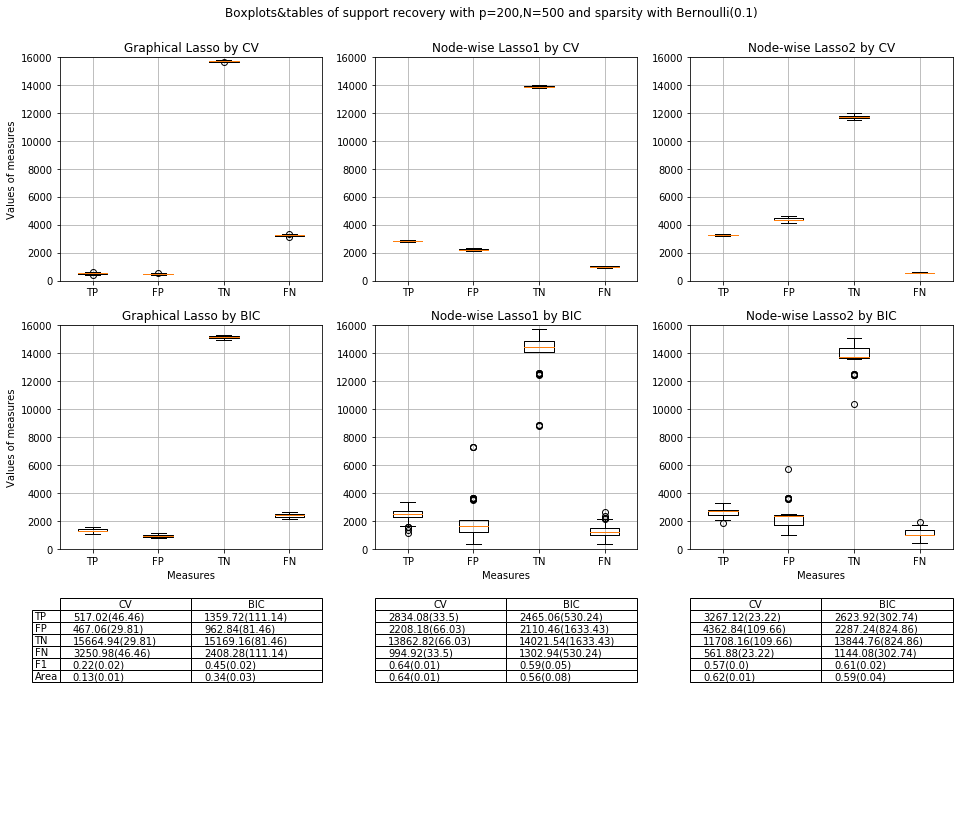

In [17]:
fig, ax = plt.subplots(3,3,figsize=(16,14))
ax[0][0].boxplot(l1[:4])
ax[1][0].boxplot(l2[:4])

ax[0][1].boxplot(l3[:4])
ax[1][1].boxplot(l4[:4])

ax[0][2].boxplot(l5[:4])
ax[1][2].boxplot(l6[:4])

column_labels=["CV", "BIC"]

for j in range(3):
    ax[2][j].axis("tight")
    ax[2][j].axis("off")
ax[2][0].table(cellText=data_GRL,colLabels=column_labels,rowLabels=["TP","FP","TN","FN","F1","Area"],cellLoc="left",loc="upper center")
ax[2][1].table(cellText=data_NWL1,colLabels=column_labels, cellLoc="left",loc="upper center")
ax[2][2].table(cellText=data_NWL2,colLabels=column_labels, cellLoc="left",loc="upper center")

ax[0][0].set_title("Graphical Lasso by CV")
ax[1][0].set_title("Graphical Lasso by BIC")
ax[0][1].set_title("Node-wise Lasso1 by CV")
ax[1][1].set_title("Node-wise Lasso1 by BIC")
ax[0][2].set_title("Node-wise Lasso2 by CV")
ax[1][2].set_title("Node-wise Lasso2 by BIC")

for i in range(2):
    for j in range(3):
        if i==1:
            ax[i][j].set_xlabel("Measures")
        if j==0:
            ax[i][j].set_ylabel("Values of measures")
        ax[i][j].set_ylim(0,16000)
        ax[i][j].set_xticks([1,2,3,4])
        ax[i][j].set_xticklabels(["TP","FP","TN","FN"])
        ax[i][j].grid()
fig.suptitle("Boxplots&tables of support recovery with p=200,N=500 and sparsity with Bernoulli(0.1)", y=0.93)
#plt.savefig("P100_N2000.pdf")
plt.show()